# Predicting Building damage grade - hosted by DrivenData

Based on aspects of building location and construction, the goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal. 

The dataset was collected through surveys by Kathmandu Living Labs and the Central Bureau of Statistics, which works under the National Planning Commission Secretariat of Nepal. This survey is one of the largest post-disaster datasets ever collected, containing valuable information on earthquake impacts, household conditions, and socio-economic-demographic statistics.

We're trying to predict the ordinal variable **damage_grade**, which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:
 - 1 represents low damage
 - 2 represents a medium amount of damage
 - 3 represents almost complete destruction


In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from scipy import stats
import statistics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import time
import seaborn as sns
# for preprocessing the data
from sklearn.preprocessing import StandardScaler
import pickle

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from mord import LogisticAT
import xgboost as xgb
from catboost import CatBoostClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
# Dataset
os.chdir("C:\\Data Science Projects\\DrivenData\\Richter's Predictor Modeling Earthquake Damage")

def get_datasets():
    dataset = pd.read_csv("train_values.csv")
    train_label = pd.read_csv("train_labels.csv")
    dataset = pd.merge(dataset, train_label, on='building_id', how='left')
    dataset = dataset[dataset['damage_grade'].isin([1.0,2.0,3.0])]
    #dataset = dataset.drop('position', axis = 1)
    test_values = pd.read_csv("test_values.csv")
    return dataset, test_values

dataset, test_values = get_datasets()


In [3]:
print(dataset.shape)
dataset.head()

(260601, 40)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


## Data Exploration

Dataset contains 260K rows with 40 columns.

We have a detailed description of each of the columns in the link **https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/**

We have to go through each of those features to understand what is good and what isn't. We can start with first looking at the depending variable (y).


In [4]:
print(dataset.groupby('damage_grade')['building_id'].count())

dataset.groupby('damage_grade')['building_id'].count()/sum(dataset.groupby('damage_grade')['building_id'].count())

damage_grade
1     25124
2    148259
3     87218
Name: building_id, dtype: int64


damage_grade
1    0.096408
2    0.568912
3    0.334680
Name: building_id, dtype: float64

56% fall under damage grade 2, 9.6% in 1 and 33% in 3

Let's dive deeper into the features to understand what would help us predict the damage.

In [5]:
dataset.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

Seems like we do not have any missing data (credits to DrivenData).


## Univariate analysis:

Let's look at a couple of features for Univariate analysis

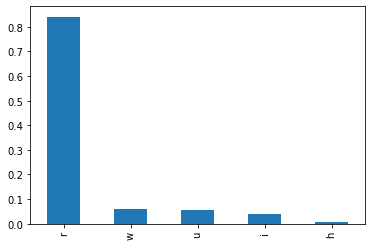

In [6]:
(dataset['foundation_type'].value_counts()/np.sum(dataset['foundation_type'].value_counts())).plot('bar')

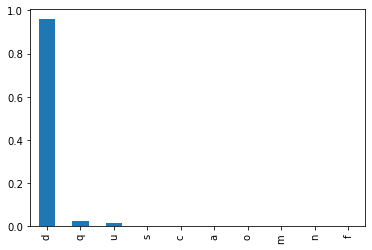

In [7]:
(dataset['plan_configuration'].value_counts()/np.sum(dataset['plan_configuration'].value_counts())).plot('bar')

We will be eliminating 'plan_configuration' but keeping 'foundation_type'. Similarly we will remove few other features where we have 95% values in one category. 

Also, we will be clubbing categories that do not have a significant % of values, for ex, we will club 'h','i', 'u', 'w' into 'u' (Note: we are creating a new bucket here called 'Others', and not categorising these into 'u', although we are retaining 'u' for simplicity). 

Let's visualize each of the features with respect to the dependant variable through graphs to understand it better.

In [8]:
def perc_stacked_graph(dataset, X, Y, Z):
    perc_stacked = dataset.pivot_table(index=[X], columns=Y, values=Z, aggfunc='count').reset_index()
    #perc_stacked.drop(['land_surface_condition'], axis=1)

    perc_stacked = perc_stacked.set_index(perc_stacked[X], drop=True)
    perc_stacked = perc_stacked.drop([X], axis=1)
    for row in perc_stacked.index:
        perc_stacked.loc[row] = perc_stacked.loc[row]/np.sum(perc_stacked.loc[row], axis=0)
    perc_stacked.plot(kind='bar')

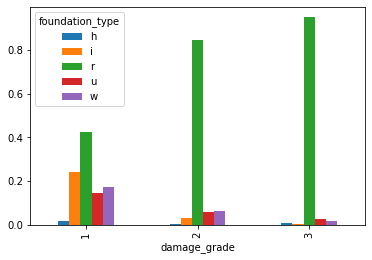

In [9]:
perc_stacked_graph(dataset, "damage_grade", "foundation_type", "building_id")

We can say from the above graph that for foundation type 'w', damage grade is more likely to be 1 and for 'r', its 2 or 3.
A better/newer foundation might have suffered lesser damage. 'u'. 'i' and 'w' could have been better foundations (although we don't have this information, this could easily be a good predictor if we have more context)

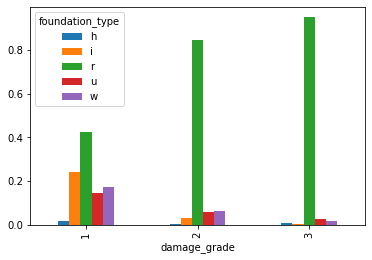

In [10]:
perc_stacked_graph(dataset, "damage_grade", "foundation_type", "building_id")

Geo ID seems to be a great predictor too. After all, some places are bound to be more affected than others - geographically prone areas, area with older buildings, etc.

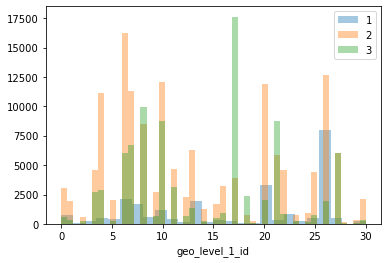

In [11]:
fig, ax = plt.subplots()
for a in [1, 2, 3]:
    sns.distplot(dataset[dataset['damage_grade'] == a]['geo_level_1_id'], ax=ax, kde=False)
ax.legend(['1','2','3'])

Specific Geo IDs seem to have higher damage grade, for ex, area ID 17 has more damage grade 3 and area IDs 20, 30, etc. have damage grades 2. This also seems like a good predictor


## Bi-Variate Analysis:

We will look at the Pearson's correlation and Chi Square test to identify highly correlated variables. Having highly correlated variables makes it difficult for the model to establish the right relationships with the variables.

In [12]:
def pearson_cor(dataset):
    pearsoncorr = dataset._get_numeric_data().corr()
    """sns.heatmap(pearsoncorr, 
                xticklabels=pearsoncorr.columns,
                yticklabels=pearsoncorr.columns,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.5)"""
    #pearsoncorr.to_csv("correlation matrix.csv")
    return pearsoncorr
pearson_cor(dataset).head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,1.000000,-0.002850,0.000347,-0.000393,-0.000654,-0.001476,-0.002070,0.000096,-0.000307,0.002423,...,0.001934,-0.002152,0.000706,-0.000362,0.002348,-0.000374,0.000538,-0.003116,-0.002295,0.001063
geo_level_1_id,-0.002850,1.000000,-0.061405,0.002718,-0.089364,-0.003908,0.071158,-0.063474,-0.018245,-0.152038,...,0.001911,0.023523,0.003700,0.002977,0.002655,-0.002303,0.001060,0.000523,-0.017992,-0.072347
geo_level_2_id,0.000347,-0.061405,1.000000,0.000921,0.047730,0.012594,-0.049443,0.035516,0.015833,0.076491,...,-0.008439,-0.030704,-0.004840,-0.004856,0.000687,-0.000757,-0.000152,0.001926,-0.013068,0.043161
geo_level_3_id,-0.000393,0.002718,0.000921,1.000000,-0.021646,-0.006385,-0.005643,-0.024507,-0.015732,0.026294,...,-0.002001,-0.007356,-0.007058,-0.004373,-0.000862,-0.002632,-0.000943,0.000269,-0.002463,0.007932
count_floors_pre_eq,-0.000654,-0.089364,0.047730,-0.021646,1.000000,0.086668,0.101071,0.772734,0.174852,-0.027116,...,0.077120,0.035425,0.016384,0.008833,-0.002611,0.006786,0.009639,0.003939,-0.002073,0.122308


In [13]:
def chi_square_test(dataset):
    categ_col_list = dataset.select_dtypes(exclude='number').columns
    chi_df = pd.DataFrame(columns=categ_col_list, index=categ_col_list)
    for i in categ_col_list:
        for j in categ_col_list:
            cross = pd.crosstab(dataset[i], dataset[j])

            chi_stat = stats.chi2_contingency(cross)
            p_chi_stat = chi_stat[1]
            chi_df.loc[i,j] = p_chi_stat
    return chi_df
chi_sq = chi_square_test(dataset)
chi_sq[chi_sq > 0.05]

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
land_surface_condition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
foundation_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
roof_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ground_floor_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
other_floor_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
plan_configuration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
legal_ownership_status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Summarizing data cleaning:

 - subgrouping categories for some features
 - dropping high skewed features
 - dropping highly correlated variables
 - changing datatypes

In [14]:
# Data Cleaning

def clean_data(dataset):
    # Age
    #dataset.loc[(dataset['age']>=120) | (dataset['age']==0), 'age'] = np.mean(dataset['age'])
    #dataset.loc[dataset['age']>=70, 'age'] = 70

    # land_surface_condition
    dataset['land_surface_condition'] = dataset['land_surface_condition'].astype(str)
    dataset.loc[~(dataset['land_surface_condition'].isin(['n','o','t'])), 'land_surface_condition'] = statistics.mode(dataset['land_surface_condition'])

    dataset.loc[dataset['land_surface_condition'].isin(['o','n']), 'land_surface_condition'] = 'n'
    # foundation_type
    dataset.loc[dataset['foundation_type'].isin(['h','i', 'u', 'w']), 'foundation_type'] = 'u'

    # ground_floor_type
    dataset.loc[dataset['ground_floor_type'].isin(['m','x', 'z']), 'ground_floor_type'] = 'x'

    # other_floor_type
    dataset.loc[dataset['other_floor_type'].isin(['j','s']), 'other_floor_type'] = 'j'

    # count_families
    dataset.loc[dataset['count_families'] >= 2, 'count_families'] = 2

    # Drop due to no visual variance in bar graphs
    #dataset = dataset.drop(['position'], axis=1)



    # Drop due to skewness
    dataset = dataset.drop(['plan_configuration'
                            ,'plan_configuration'
                            ,'has_superstructure_cement_mortar_stone'
                            ,'has_superstructure_mud_mortar_brick'
                            ,'has_superstructure_rc_engineered'
                            ,'has_superstructure_other'
                            ,'legal_ownership_status'
                            ,'has_secondary_use_hotel'
                            ,'has_secondary_use_rental'
                            ,'has_secondary_use_institution'
                            ,'has_secondary_use_school'
                            ,'has_secondary_use_industry'
                            ,'has_secondary_use_health_post'
                            ,'has_secondary_use_gov_office'
                            ,'has_secondary_use_use_police'
                            ,'has_secondary_use_other'
                           ], axis=1)
    #dataset.loc[dataset['geo_level_1_id'] <= 10, 'geo_level_1_id'] = 100
    #dataset.loc[(dataset['geo_level_1_id'] > 10) & (dataset['geo_level_1_id'] <= 20), 'geo_level_1_id'] = 200
    #dataset.loc[(dataset['geo_level_1_id'] > 20) & (dataset['geo_level_1_id'] <= 30), 'geo_level_1_id'] = 300
    
    dataset = dataset.drop(['building_id'], axis=1)
    
    # Drop due to high correlation from Pearson's correlation
    dataset = dataset.drop(['height_percentage', 'has_secondary_use_agriculture'], axis=1)
    return dataset
#dataset = clean_data(dataset)

## Model Building:

We will now try the below models with a test/train split of 80/20:

 - Random Forests
 - XGBoost
 - Logistic Regression
 - Linear Regression
 - One vs Rest Logistic
 - Ordinal Logistic
 - CatBoost

We will use **micro averaged F1 score** as our metric for evaluation


In [15]:
dataset, test_values = get_datasets()
dataset = dataset.drop(['position'], axis=1)
dataset = clean_data(dataset)
#dataset = secondary_clean_data(dataset)


In [16]:
def create_test_train(dataset):
    X = dataset.drop('damage_grade', axis=1)
    Y = dataset['damage_grade']
    X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=2020)
    return(X_train, X_test, y_train, y_test)


X_train, X_test, y_train, y_test = create_test_train(dataset)
X_train.shape


(208480, 20)

In [35]:
X_train_dum = pd.get_dummies(X_train)
X_train.head()
X_test_dum = pd.get_dummies(X_test)

In [20]:

logreg = LogisticRegression(solver='lbfgs', max_iter = 500)
logreg.fit(X_train, y_train)
#X_test['geo_level_2_id'] = (X_test['geo_level_2_id'] - np.min(X_test['geo_level_2_id']))/(np.max(X_test['geo_level_2_id']) - np.min(X_test['geo_level_2_id']))
#X_test['geo_level_3_id'] = (X_test['geo_level_3_id'] - np.min(X_test['geo_level_3_id']))/(np.max(X_test['geo_level_3_id']) - np.min(X_test['geo_level_3_id']))
#X_test = pd.get_dummies(X_test)
in_sample_preds_log = logreg.predict(X_test)
print("F1 Score - Test: ", f1_score(y_test, in_sample_preds_log, average='micro'))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


F1 Score - Test:  0.5742215229945703


In [21]:
# Linear Regression
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
in_sample_preds_lin = model_linear.predict(X_test)
print("F1 Score - Test: ", f1_score(y_test, np.round(in_sample_preds_lin), average='micro'))

F1 Score - Test:  0.5723220966596957


In [22]:
# 1 vs Rest
model_1vR = LogisticRegression(multi_class='ovr', class_weight='balanced', max_iter=500)
model_1vR.fit(X_train, y_train)
in_sample_preds_1vR = model_1vR.predict(X_test)
print("F1 Score - Test: ", f1_score(y_test, np.round(in_sample_preds_1vR), average='micro'))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score - Test:  0.5471882734406477


In [18]:
# Ordinal Logistic
model_ordinal = LogisticAT(alpha=0)
model_ordinal.fit(X_train, y_train)
in_sample_preds_ord = model_ordinal.predict(X_test)
print("F1 Score - Test: ", f1_score(y_test, np.round(in_sample_preds_ord), average='micro'))

F1 Score - Test:  0.574681989984843


In [33]:
# Random Forest
def random_forest_model(X_train, y_train):
    
    pipe = make_pipeline(StandardScaler(), 
                         RandomForestClassifier(random_state=2020, n_jobs=-1))
    pipe

    param_grid = {'randomforestclassifier__n_estimators': [500],
                  'randomforestclassifier__min_samples_leaf': [5]}
    gs = GridSearchCV(pipe, param_grid, cv=5)
    X_train = pd.get_dummies(X_train)
    gs.fit(X_train, y_train.values.ravel())
    print(gs.best_params_)

    return gs

start = time.process_time()
gs = random_forest_model(X_train, y_train)
print(time.process_time() - start)

{'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 500}
661.1875


In [34]:
X_train = pd.get_dummies(X_train)
in_sample_preds = gs.predict(X_train)
print("F1 Score - Train: ", f1_score(y_train, in_sample_preds, average='micro'))

X_test = pd.get_dummies(X_test)
in_sample_preds_rf = gs.predict(X_test)
print("F1 Score - Test: ", f1_score(y_test, in_sample_preds_rf, average='micro'))

F1 Score - Train:  0.7793649270913277
F1 Score - Test:  0.7232785249707412


In [28]:
# XGBoost
xgb1 = xgb.XGBClassifier(
learning_rate =0.2,
n_estimators=1260,
max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'multi:softmax',
scale_pos_weight=0,
seed=27,
num_class=3)

start = time.process_time()

param_test1 = {'max_depth':[5],
 'min_child_weight':[1]
}

#gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, cv =5)
#gsearch1.fit(X_train, y_train)
#print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

print(time.process_time() - start)

KeyboardInterrupt: 

In [23]:
xgb1 = pickle.load(open("DD_xgb.sav", 'rb'))

C:\Users\shash\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\shash\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [31]:
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1260, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=0,
              seed=27, silent=None, subsample=0.8, verbosity=1)

In [32]:
import pickle
DD_xgb = pickle.dump(xgb1, open("DD_xgb.sav", "wb"))

In [ ]:
xgb_param = xgb1.get_xgb_params()
xgb_param

xgdmat = xgb.DMatrix(X_train_dum, y_train.values-1)
cvresult = xgb.cv(xgb_param, xgdmat, num_boost_round=xgb1.get_params()['n_estimators'], nfold=3,
            early_stopping_rounds=100)
xgb1.set_params(n_estimators=cvresult.shape[0])

xgb1.fit(X_train, y_train.values-1)

In [26]:
test_xgb = xgb.DMatrix(X_test)
in_sample_preds_xgb= (xgb1.predict(X_test)).astype(int)
print("F1 Score - Test: ", f1_score(y_test, in_sample_preds_xgb, average='micro'))

F1 Score - Test:  0.747050133343566


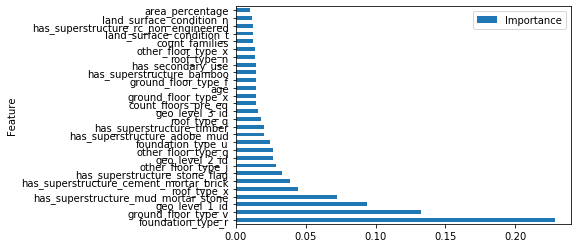

In [57]:
imp_df = []
for col, imp in zip(X_train_dum.columns, xgb1.feature_importances_):
    imp_df.append([col,imp])
imp_df = pd.DataFrame(imp_df, columns=['Feature', 'Importance'])
imp_df = imp_df.sort_values('Importance', ascending = False).reset_index(drop=True)
imp_df.set_index('Feature').plot(kind='barh')

In [30]:
#cb=CatBoostClassifier(learning_rate=0.2,depth=8,boosting_type='Plain',eval_metric='Accuracy',n_estimators=2000,random_state=294, verbose=0)
def cat_hyp(depth, l2_leaf_reg):
    params = {'learning_rate' : 0.25,
             'boosting_type':'Plain',
             'eval_metric':'Accuracy',
              'n_estimators':200}
    params['depth'] = depth
    params['l2_leaf_reg'] = l2_leaf_reg
    cb = CatBoostClassifier(params,random_state=294, verbose=0)
    cb.fit(X_train_dum,y_train)
    f1_score(y_test, in_sample_preds_cat, average='micro')

In [31]:
params = {'depth':[3,5,7],
          #'iterations':[500],
          'learning_rate':[0.2,0.3], 
          'l2_leaf_reg':[3,5,10],
          'border_count':[32,5,50],
          #'ctr_border_count':[50,5,10,100],
          #'thread_count':4
         }

In [36]:
cb = CatBoostClassifier(boosting_type='Plain', n_estimators=300, verbose=2, task_type='GPU')
cb_model = GridSearchCV(cb, params, scoring="f1_macro", cv = 2, verbose=10)
cb_model.fit(X_train_dum, y_train)

0:	learn: 1.0149340	total: 9.87ms	remaining: 2.95s
2:	learn: 0.9069131	total: 22.6ms	remaining: 2.23s
4:	learn: 0.8525995	total: 38.2ms	remaining: 2.25s
6:	learn: 0.8154148	total: 50.4ms	remaining: 2.11s
8:	learn: 0.7925841	total: 65.7ms	remaining: 2.12s
10:	learn: 0.7787299	total: 77.6ms	remaining: 2.04s
12:	learn: 0.7685535	total: 90ms	remaining: 1.99s
14:	learn: 0.7621717	total: 101ms	remaining: 1.93s
16:	learn: 0.7581845	total: 113ms	remaining: 1.88s
18:	learn: 0.7475689	total: 126ms	remaining: 1.87s
20:	learn: 0.7435247	total: 139ms	remaining: 1.85s
22:	learn: 0.7396968	total: 151ms	remaining: 1.82s
24:	learn: 0.7369835	total: 165ms	remaining: 1.82s
26:	learn: 0.7347371	total: 179ms	remaining: 1.8s
28:	learn: 0.7302255	total: 190ms	remaining: 1.77s
30:	learn: 0.7281129	total: 204ms	remaining: 1.77s
32:	learn: 0.7255828	total: 218ms	remaining: 1.76s
34:	learn: 0.7226112	total: 231ms	remaining: 1.75s
36:	learn: 0.7211880	total: 244ms	remaining: 1.73s
38:	learn: 0.7197521	total: 256m

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000019DA4C29F98>,
             param_grid={'border_count': [32, 5, 50], 'depth': [3, 5, 7],
                         'l2_leaf_reg': [3, 5, 10],
                         'learning_rate': [0.2, 0.3]},
             scoring='f1_macro')

In [43]:
cb_model.best_params_

{'border_count': 50, 'depth': 7, 'l2_leaf_reg': 3, 'learning_rate': 0.3}

In [45]:
in_sample_preds_cb = cb_model.predict(X_test_dum)
print("F1 Score - Test: ", f1_score(y_test, in_sample_preds_xgb, average='micro'))

F1 Score - Test:  0.747050133343566


In [ ]:
# Submission
dataset_dum = pd.get_dummies(dataset)


test_values = clean_data(test_values)
test_values = test_values.drop(['position'], axis=1)
#test_values = secondary_clean_data(test_values)
test_values_dum = pd.get_dummies(test_values)
sub_preds = xgb1.predict(test_values_dum)
test_values = pd.read_csv("test_values.csv")
sub_df = pd.DataFrame(test_values['building_id'].values, columns=['building_id'])
sub_df['damage_grade'] = sub_preds
sub_df.to_csv("Richter_damage_9.csv", index=False)

Both CatBoost and XGBoost are giving similar results. Final submission was made using results from XGBoost. Accuracy in Public Leaderboard was 74.36% and top accuracy is 75.5%